In [1]:
%load_ext jupyternotify

import os
import itertools
import multiprocessing
import csv

import numpy as np
import matplotlib.pyplot as plt
# i use numba to jit compile the code. makes it about 5x faster.
# it makes debuging harder and the code a bit 'non-pythonic'
# one may comment out the @njit decorators if you don't want it. 
# using find and replace from edit menu and choosing all cells
from numba import njit

from scipy.constants import e, k, h
from scipy.interpolate import interp1d
from scipy.optimize import minimize, basinhopping
from scipy.stats import linregress

DELTA = 0.250*1e-3*e
ROK_ENERGY_UNIT = (DELTA/0.166)

V_RANGE = 0.605
FREQUENCY = 2*np.pi*368*1e6

<IPython.core.display.Javascript object>

In [2]:
@njit
def gamma(g0, v0, T, N):
    numerator = np.exp(v0/(k*T)) + N
    denominator = np.exp(v0/(k*T)) - 1
    return g0*numerator/denominator

@njit
def etta(g0, v0, T, N):
    numerator = N*gamma(g0, v0, T, N)
    denominator = 4*k*T*((np.cosh(v0/(2*k*T)))**2)
    return numerator/denominator

@njit
def llambda(v0, T, N):
    numerator = np.exp(v0/(k*T)) + 1
    denominator = np.exp(v0/(k*T)) + N
    return numerator/denominator

@njit
def p0(smg, T, N):
    numerator = np.exp(smg/(k*T))
    denominator = np.exp(smg/(k*T)) + N
    return numerator/denominator

@njit
def q_capacitance(smg, T, N, dne, dng):
    return (e**2) * (p0(smg, T, N)*(dne - dng) - dne)

@njit
def tunnel_capacitance(g0, smg, dsmg, T, N, ne, ng, w):
    numerator = (e**2)*etta(g0, smg, T, N)*(llambda(smg, T, N)**2)*dsmg*(ne - ng)*gamma(g0, smg, T, N)
    denominator = gamma(g0, smg, T, N)**2 + w**2
    return numerator/denominator

@njit
def total_capacitance(g0, smg, dsmg, T, N, ne, ng, dne, dng, w):
    return tunnel_capacitance(g0, smg, dsmg, T, N, ne, ng, w) + q_capacitance(smg, T, N, dne, dng)

@njit
def conductance(g0, smg, dsmg, T, N, ne, ng, w):
    numerator = (e**2)*etta(g0, smg, T, N)*(llambda(smg, T, N)**2)*dsmg*(ne - ng)*(w**2)
    denominator = gamma(g0, smg, T, N)**2 + w**2
    return numerator/denominator

In [3]:
# NRG_PATH = f"f1web.ijs.si\\~zitko\\data\\chi\\"
NRG_PATH = f"f1web.ijs.si/~zitko/data/chi/"

U_SET = tuple(np.sort([float(file_names[2:]) for file_names in os.listdir(NRG_PATH) if file_names[0:2] == 'U=']))

GAMMA_DICT = tuple(np.array([file_names.split('=')[-1]
                              for file_names in os.listdir(NRG_PATH + f'U={u_values}') if file_names[0:2] == 'U='
                             ]) for u_values in U_SET)

@njit
def gamma_dict_func(u):
    for idx, u_values in enumerate(U_SET):
        if u_values==u:
            return GAMMA_DICT[idx]

optical1_data = tuple([
    np.array([np.genfromtxt(f"{NRG_PATH}U={u_values}/U={u_values}_Gamma={gamma}/optical1.dat")[:400]
        for gamma in gamma_dict_func(u_values)
    ]) for u_values in U_SET])

n1_data = tuple([
    np.array([np.genfromtxt(f"{NRG_PATH}U={u_values}/U={u_values}_Gamma={gamma}/n1.dat")[:400]
        for gamma in gamma_dict_func(u_values)
    ]) for u_values in U_SET])

n2_data = tuple([
    np.array([np.genfromtxt(f"{NRG_PATH}U={u_values}/U={u_values}_Gamma={gamma}/n2.dat")[:400]
        for gamma in gamma_dict_func(u_values)
    ]) for u_values in U_SET])
        
@njit
def nrg_data_func(u,gamma):
    gamma_set = gamma_dict_func(u)
    for idx in range(len(gamma_set)):
        if gamma_set[idx]==gamma:
            u_idx = U_SET.index(u)
            nrg_data = [optical1_data[u_idx][idx,:,:], n1_data[u_idx][idx,:,:], n2_data[u_idx][idx,:,:]]
            return nrg_data      

In [4]:
U_SET

(0.166, 0.249, 0.333, 0.375, 0.416, 0.45, 0.5, 0.666, 1.0)

In [5]:
# nrg_data_func(0.5,'0.00250')[1][23]

In [6]:
EXPERIMENTAL_PATH = "G:/My Drive/GROWTH/Quantum computing/Majorana Project/Experimental data/opening_parity/opening_parity_1/"

DATA_SETS_LIST = np.round([-159.8+0.1*idx for idx in range(5,184,17)],1)

EXPERIMENTAL_DATA = np.array([np.loadtxt(f"{EXPERIMENTAL_PATH}dataset_opening_parity_1_{data_set}.csv",
                                         skiprows = 1,
                                         delimiter = ',')[:, [0, 1, 2]] for data_set in DATA_SETS_LIST])

@njit
def dataset_func(data_idx):
    for idx, data_set in enumerate(DATA_SETS_LIST):
        if data_set==data_idx:
            return EXPERIMENTAL_DATA[idx,:,0:2], EXPERIMENTAL_DATA[idx,:,0:3:2]


In [7]:
@njit
def experimental_data(data_idx,symmetrize): #filter
    c_data, r_data = dataset_func(data_idx)
    
    exp_c = c_data[:,1]
    exp_g = r_data[:,1]
    exp_v = (c_data[:,0] - np.mean(c_data[:,0]))*1e3
    
    filter_bool = (exp_v < V_RANGE) * (-V_RANGE < exp_v)
    
    exp_c = exp_c[filter_bool]*1e15
    exp_g = exp_g[filter_bool]*1e8
    exp_v = exp_v[filter_bool]
    
    if symmetrize:
        exp_c = (exp_c + exp_c[::-1])/2
        exp_g = (exp_g + exp_g[::-1])/2
        
    return exp_v, exp_c, exp_g


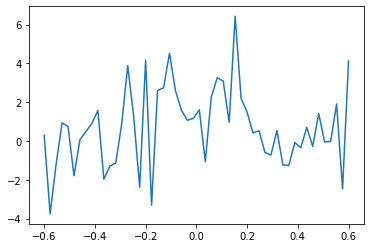

In [8]:
ider = 10
plt.plot(experimental_data(DATA_SETS_LIST[ider],0)[0], experimental_data(DATA_SETS_LIST[ider],0)[2])

In [9]:
@njit
def analytical_data(gamma, log_g0, global_parameters, v0,fit_step):
    u, alpha, temp, log_n = global_parameters
    
    v0 = v0*alpha
    normunit = ROK_ENERGY_UNIT*1e3/e
    
    nu = (1 - v0/(u*normunit))
    n = 10**log_n
    g0 = 10**log_g0
    if log_g0 == 0.0: g0 = 0.0
    w = FREQUENCY
    
    o1, n1, n2 = nrg_data_func(u,gamma)
    
    s_mg = np.interp(nu, o1[:,0], o1[:, 1])*DELTA
    n_g  = np.interp(nu, n1[:,0], n1[:, 1])
    n_e  = np.interp(nu, n2[:,0], n2[:, 1])
    dn_g = np.interp(nu, n1[1:,0], (n1[1:, 1] - n1[:-1, 1]) / (-0.01*u)) / ROK_ENERGY_UNIT
    dn_e = np.interp(nu, n2[1:,0], (n2[1:, 1] - n2[:-1, 1]) / (-0.01*u)) / ROK_ENERGY_UNIT
    
    dn_g = (dn_g + dn_g[::-1])/2
    dn_e = (dn_e + dn_e[::-1])/2
    
    if fit_step == 1:
        q_caps = alpha*alpha*q_capacitance(s_mg, temp, n, dn_e, dn_g)*1e15
        return q_caps, q_caps, q_caps
    
    ds_mg = np.interp(nu, o1[1:, 0], (o1[1:, 1] - o1[:-1, 1]) / (-0.01*u)) * DELTA / ROK_ENERGY_UNIT
    
    q_caps = alpha*alpha*q_capacitance(s_mg, temp, n, dn_e, dn_g)*1e15
    t_caps = alpha*alpha*tunnel_capacitance(g0, s_mg, ds_mg, temp, n, n_e, n_g, w)*1e15
    t_caps = (t_caps + t_caps[::-1])/2
    c_total = q_caps + t_caps
    
    couduc = alpha*alpha*conductance(g0, s_mg, ds_mg, temp, n, n_e, n_g, w)*1e8
    couduc = (couduc + couduc[::-1])/2
    
    return q_caps, c_total, couduc

In [14]:
#Fitting Step 1
@njit
def grad(f,dx):
    return (f[1:] - f[:-1])/dx

@njit
def weight_def(gamma, dset, global_parameters, sym):
    u, alpha, temp, log_n = global_parameters
    cap_thresh = 0.027 #fF
    exp_v, exp_c, _ = experimental_data(dset, sym)
    q_caps, _, _ = analytical_data(gamma, 0.0, global_parameters, exp_v, fit_step = 1)
    weight_qc = ((q_caps - exp_c)**2) / (np.maximum(cap_thresh, (q_caps + exp_c)/2)**2) * (1 - np.abs(exp_v)/V_RANGE)
#     print(np.sum(weight_qc))
    if dset != DATA_SETS_LIST[-1]: # dips present
        if grad(grad(q_caps,0.01),0.01)[np.argmin(np.abs(grad(q_caps,0.01)))] < 0:
            
            return np.sum(weight_qc) + 100
            
    
#     weight_int = ((np.trapz(y=q_caps,x=exp_v) - np.trapz(y=exp_c,x=exp_v))/(np.mean((q_caps + exp_c)/2)))**2
#     print(weight_int)
    return np.sum(weight_qc) #+ 10*weight_int

@njit
def min_gamma_weight(dset, global_parameters, sym):
    u, alpha, temp, log_n = global_parameters
    gamma_set = gamma_dict_func(u)
    weight_set = np.array([weight_def(gamma, dset, global_parameters, sym) for gamma in gamma_set])
    weight_min_idx = np.argmin(weight_set)
    return gamma_set[weight_min_idx], weight_set[weight_min_idx]

@njit
def total_weight(global_parameters,sym):
    u, alpha, temp, log_n = global_parameters
    data_sets = DATA_SETS_LIST
    weight_set = np.array(
        [
            min_gamma_weight(sets, (u, alpha, temp, log_n), sym)[1] 
            for sets in data_sets
        ])
    total_weight = np.sum(weight_set)
    return total_weight

# @njit
def total_weight_cont(continous_parameters,u,sym):
    return total_weight((u,*continous_parameters),sym)
    
def plot_optimal_values(dset, global_parameters, sym):
    exp_v, exp_c, _ = experimental_data(dset, sym)
    
    gamma, weit = min_gamma_weight(dset, global_parameters, sym)
    print(gamma, weit)
    q_caps,_,_ = analytical_data(gamma, 0.0, global_parameters, exp_v, fit_step = 1)
    
    fig, axes = plt.subplots(1,1)
    axes.plot(exp_v, exp_c)
    axes.plot(exp_v, q_caps)

In [15]:
# if all is well with the code, this should be True
# (np.allclose(total_weight((0.333, 0.5, 10.0/100, 6.0),1), 92.98885139954356) and 
# np.allclose(total_weight_cont((0.62466789, 11.27579307/100, 5.69590558),0.416,1), 109.98813495599569))
total_weight((0.333, 0.5, 10.0/100, 6.0),1)

60.39265313983667

In [16]:
# %%timeit -n 50 -r 10 -c -p 4 -o -q
# #performance check

# total_weight((0.333, 0.5, 10.0/100, 6.0),1)
# total_weight_cont((0.62466789, 11.27579307/100, 5.69590558),0.416,1)

# # <TimeitResult : 25.04 ms ± 1.089 ms per loop (mean ± std. dev. of 10 runs, 50 loops each)>

In [17]:
def minimize_qc(u,sym):
    inital_x = (0.5, 0.1, 6.0)
    result = basinhopping(total_weight_cont,
                          inital_x,
                          minimizer_kwargs={'args':(u, sym),"method": 'trust-constr'},
#                           hess = lambda x: numpy.zeros((len(inital_x), len(inital_x))),
                          niter=30,
#                           T=10,
#                           stepsize=2
                         )
    result = result.lowest_optimization_result
    return_set = [u, result.success]
    if result.success:
        return_set.append(result.fun)
        return_set.append(result.x)
    return return_set


In [322]:
%%time
%%notify
def results_qc(u,sym):
    results = []
    for u_values in u:
        print(u_values)
        return_set = minimize_qc(u_values,sym)
        print(return_set)
        results.append(return_set)
    return results

# def parallel_func(params):
#     return minimize_qc(*params)

# def results_qc(u,sym):
#     apool = multiprocessing.Pool()
#     results = apool.map(parallel_func,list(itertools.product(u,[sym])))
    
#     return results

STEP1_RESULTS = results_qc(U_SET[2:5:2],0) #U_SET[2:5:2]


0.333


C:\Users\rupes\miniconda3\envs\bourne\lib\site-packages\scipy\optimize\_trustregion_constr\equality_constrained_sqp.py:152: RuntimeWarning: invalid value encountered in double_scalars
  actual_reduction = merit_function - merit_function_next


[0.333, True, 175.55103183774105, array([ 0.7568283 ,  0.06873896, 12.75751586])]
0.416
[0.416, True, 180.4860040646522, array([0.67415294, 0.08638057, 6.32861244])]


<IPython.core.display.Javascript object>

CPU times: total: 3min 43s
Wall time: 3min 50s


In [323]:
STEP1_OPTIMAL = STEP1_RESULTS[0]#np.argmin([result[2] for result in STEP1_RESULTS])]
GLOBAL_OPTIMALS = np.array([STEP1_OPTIMAL[0],*STEP1_OPTIMAL[3]])
GLOBAL_OPTIMALS

array([ 0.333     ,  0.7568283 ,  0.06873896, 12.75751586])

In [324]:
gamma_values = [min_gamma_weight(sets, GLOBAL_OPTIMALS, 0)[0] for sets in DATA_SETS_LIST]
gamma_values

['0.07000',
 '0.05750',
 '0.03250',
 '0.03625',
 '0.04500',
 '0.04750',
 '0.04750',
 '0.05000',
 '0.05500',
 '0.07000',
 '0.09000']

In [ ]:
#Fitting Step 2

@njit
def weight_def2(dset, global_parameters,log_g0, sym):
#     u, alpha, temp, log_n = global_parameters
    gamma = min_gamma_weight(dset, global_parameters, sym)[0]
    caps_thresh = 0.027 #fF
    cond_thresh = 1.0 #10 mu G
    exp_v, exp_c, exp_g = experimental_data(dset, sym)
    _, caps, cond = analytical_data(gamma, log_g0, global_parameters, exp_v, fit_step = 2)
    weight_c = ((caps - exp_c)**2) / (np.maximum(caps_thresh, (caps + exp_c)/2)**2) * (1 - np.abs(exp_v)/V_RANGE)
    weight_g = ((cond - exp_g)**2) / (np.maximum(cond_thresh, (cond + exp_g)/2)**2) * (1 - np.abs(exp_v)/V_RANGE)
    return gamma, np.sum(weight_c) + np.sum(weight_g)

@njit
def total_weight2(dissipative_parameters, global_parameters, sym):
    u, alpha, temp, log_n = global_parameters
    data_sets = DATA_SETS_LIST
    weight_set = np.array(
        [
            weight_def2(data_sets[idx], (u, alpha, temp, log_n), dissipative_parameters[idx], sym)[1]
            for idx in range(len(data_sets))
        ])
    total_weight = np.sum(weight_set)
    return total_weight
    
def plot_optimal_values2(dset, global_parameters,log_g0, sym):
    exp_v, exp_c, exp_g = experimental_data(dset, sym)
    
    gamma, weit = weight_def2(dset, global_parameters, log_g0, sym)
    print(gamma, weit)
    _, caps, cond = analytical_data(gamma, log_g0, global_parameters, exp_v, fit_step = 2)
    plt.close()
    fig, axes = plt.subplots(1,2)
    axes[0].plot(exp_v, exp_c)
    axes[0].plot(exp_v, caps)
    axes[1].plot(exp_v, exp_g)
    axes[1].plot(exp_v, cond)
    

In [328]:
def minimize_dissipation(global_values, sym):
    print(global_values[0])
    inital_x = (7.0,)*len(DATA_SETS_LIST)

    result = basinhopping(total_weight2,
                          inital_x, 
                          minimizer_kwargs={'args':(global_values, sym),"method": 'trust-constr'},
#                           niter=30,
#                           T=10,
#                           stepsize=2
                         )
    result = result.lowest_optimization_result
    return_set = [result.success]
    if result.success:
        return_set.append(result.fun)
        return_set.append((*global_values, *result.x))
    return return_set


In [330]:
STEP2_RESULTS = [] 
for items in np.array(STEP1_RESULTS,dtype='object')[:,[0,3]]:
    STEP2_RESULTS.append(minimize_dissipation((items[0],*items[1]),0))

0.333
0.416


In [329]:
STEP2_RESULTS

[[True,
  633.8277937320187,
  (0.333,
   0.7661593080741017,
   0.07738474309570738,
   10.950761250530906,
   7.096711784324317,
   7.802852302402095,
   6.011545620327291,
   6.513477594692533,
   6.588804000257676,
   6.9298554531995,
   6.7818720635094065,
   7.483263765845447,
   7.444141887318984,
   8.123501086306026,
   9.364056948261622)],
 [True,
  619.3260324836168,
  (0.416,
   0.8311033580818765,
   0.11093947374839776,
   5.871190310634053,
   6.269704312508808,
   7.808559126718926,
   5.756926796802249,
   6.671977300370053,
   6.77325360257208,
   6.837033406292874,
   6.869397578564987,
   7.724285882526062,
   8.199699100635076,
   10.164629890394293,
   9.363968377864436)]]

In [298]:
STEP2_RESULT = STEP2_RESULTS[1]
STEP2_RESULT

[True,
 619.3260324836168,
 (0.416,
  0.8311033580818765,
  0.11093947374839776,
  5.871190310634053,
  6.269704312508808,
  7.808559126718926,
  5.756926796802249,
  6.671977300370053,
  6.77325360257208,
  6.837033406292874,
  6.869397578564987,
  7.724285882526062,
  8.199699100635076,
  10.164629890394293,
  9.363968377864436)]

In [216]:
# %%time
# %%notify

# STEP2_RESULT = minimize_dissipation(GLOBAL_OPTIMALS,0)
# STEP2_RESULT

In [299]:
def fitting_plot_grid(full_result,sym,save=False):
    plt.close()
    u, alpha, temp, log_n, *dissipative_parameters = full_result
    dissipative_parameters = tuple(dissipative_parameters)
    global_parameters = (u, alpha, temp, log_n)
    gamma_values = [min_gamma_weight(sets, global_parameters, sym)[0] for sets in DATA_SETS_LIST]

    scale = 5
    fig, axes = plt.subplots(7,len(dissipative_parameters),figsize=(len(dissipative_parameters)*scale,7*scale))

    for gamma, dset, log_g0, axis1,axis2,axis3,axis4,axis5,axis6,axis7 in zip(gamma_values,DATA_SETS_LIST,dissipative_parameters,*axes):
        
        exp_v, exp_c, exp_g = experimental_data(dset, sym)
        q_cap, caps, cond = analytical_data(gamma, log_g0, global_parameters, exp_v, fit_step = 2)
        
        axis1.text(0.12,1.1,f'$log_{{10}} (\\Gamma^0 / Hz) = {log_g0:.3f}$',transform=axis1.transAxes, fontsize=20)
        axis1.plot(exp_v, exp_c, label=f'data set = {dset}')
        axis1.plot(exp_v, q_cap, label=f'$\Gamma_t = ${gamma}')
        axis1.legend()
        axis1.set_ylim(0.0,None)
        
        axis2.plot(exp_v, exp_c, label=f'data set = {dset}')
        axis2.plot(exp_v, caps, label=f'$\Gamma_t = ${gamma}')
        axis2.legend()
        axis2.set_ylim(0.0,None)
        
        axis3.plot(exp_v, exp_g, label=f'data set = {dset}')
        axis3.plot(exp_v, cond, label=f'$\Gamma_t = ${gamma}')
        axis3.legend()
        
        v0 = exp_v*alpha
        nu = (1 - (v0/u))
        o1, n1, n2 = nrg_data_func(u,gamma)
        
        s_mg = np.interp(nu, o1[:,0], o1[:,1])
        axis4.plot(exp_v, s_mg, label=f'$\Gamma_t = ${gamma}')
        axis4.set_ylim(0.0,2.05)
        
        n_g = np.interp(nu, n1[:,0], n1[:,1])
        n_e = np.interp(nu, n2[:,0], n2[:,1])

        axis5.plot(exp_v, n_g,label=f'$n_g$')
        axis5.plot(exp_v, n_e,label=f'$n_e$')
        axis5.legend()
        axis5.set_ylim(0.0,2.1)
        
        P0g = p0(s_mg*DELTA, temp, 10**log_n)
        axis6.plot(exp_v,P0g,label=f'$\Gamma_t = ${gamma}')
        axis6.legend()
        
        t_cap = caps - q_cap
        axis7.plot(exp_v, caps, 'k', label=r'$C_{total}$')
        axis7.plot(exp_v, q_cap, '--', label=r'$C_q$')
        axis7.plot(exp_v, t_cap, '--', label=r'$C_t$')
        axis7.legend()
        axis7.set_ylim(0.0,None)

    axes[0][0].set_ylabel(r'Quantum Capacitance, $C_Q$ (fF)',fontsize=15)
    axes[1][0].set_ylabel(r'Total Capacitance, C (fF) {$C_Q + C_t$}',fontsize=15)
    axes[2][0].set_ylabel(r'Conductance, S ($10^{-8} \Omega^{-1}$)',fontsize=15)
    axes[3][0].set_ylabel(r'Shiba mini-gap, $\delta / \Delta $',fontsize=15)
    axes[4][0].set_ylabel(r'Occupation, $n$',fontsize=15)
    axes[5][0].set_ylabel(r'P_{g,0}',fontsize=15)
    axes[6][0].set_ylabel('Capacitance, C (fF)',fontsize=15)
    axes[6][5].set_xlabel(r'$V_{P0} (mV) $',fontsize=20)
         
    parameter_string = f"$T = {temp*1000:.3f} mK $\
            $\\alpha        = {alpha:.3f} $\
            $U       = {u:.3f} *1.506 meV $\
            $log_{{10}} N   = {log_n:.3f}$"
    
    fig.text(
        0.5, 0.95, parameter_string, ha='center', va='center', wrap=False,
        bbox=dict(ec='black', alpha=1, color='azure'), fontsize=20)
    
    if sym:
        fig.text(
        0.5, 0.902, f"Symmetrized. TW = {total_weight2(dissipative_parameters, global_parameters, sym):.1f}", ha='center', va='center', wrap=False,
        bbox=dict(ec='black', alpha=0, color='azure'), fontsize=15)
    if not sym:
        fig.text(
        0.5, 0.902, f"Not Symmetrized. TW = {total_weight2(dissipative_parameters, global_parameters, sym):.1f}", ha='center', va='center', wrap=False,
        bbox=dict(ec='black', alpha=0, color='azure'), fontsize=15)
    
    if save:
        if sym:
            plt.savefig(f"2D_grid_sym_{[f'{member[0]}{member[1]:.2f}_' for member in zip(['U-', 'alpha-', 'mK_T-', 'log_N-'],global_parameters)]}.pdf", format='pdf')
        else:
            plt.savefig(f"2D_grid_not-sym_{[f'{member[0]}{member[1]:.2f}_' for member in zip(['U-', 'alpha-', 'mK_T-', 'log_N-'],global_parameters)]}.pdf", format='pdf')
      

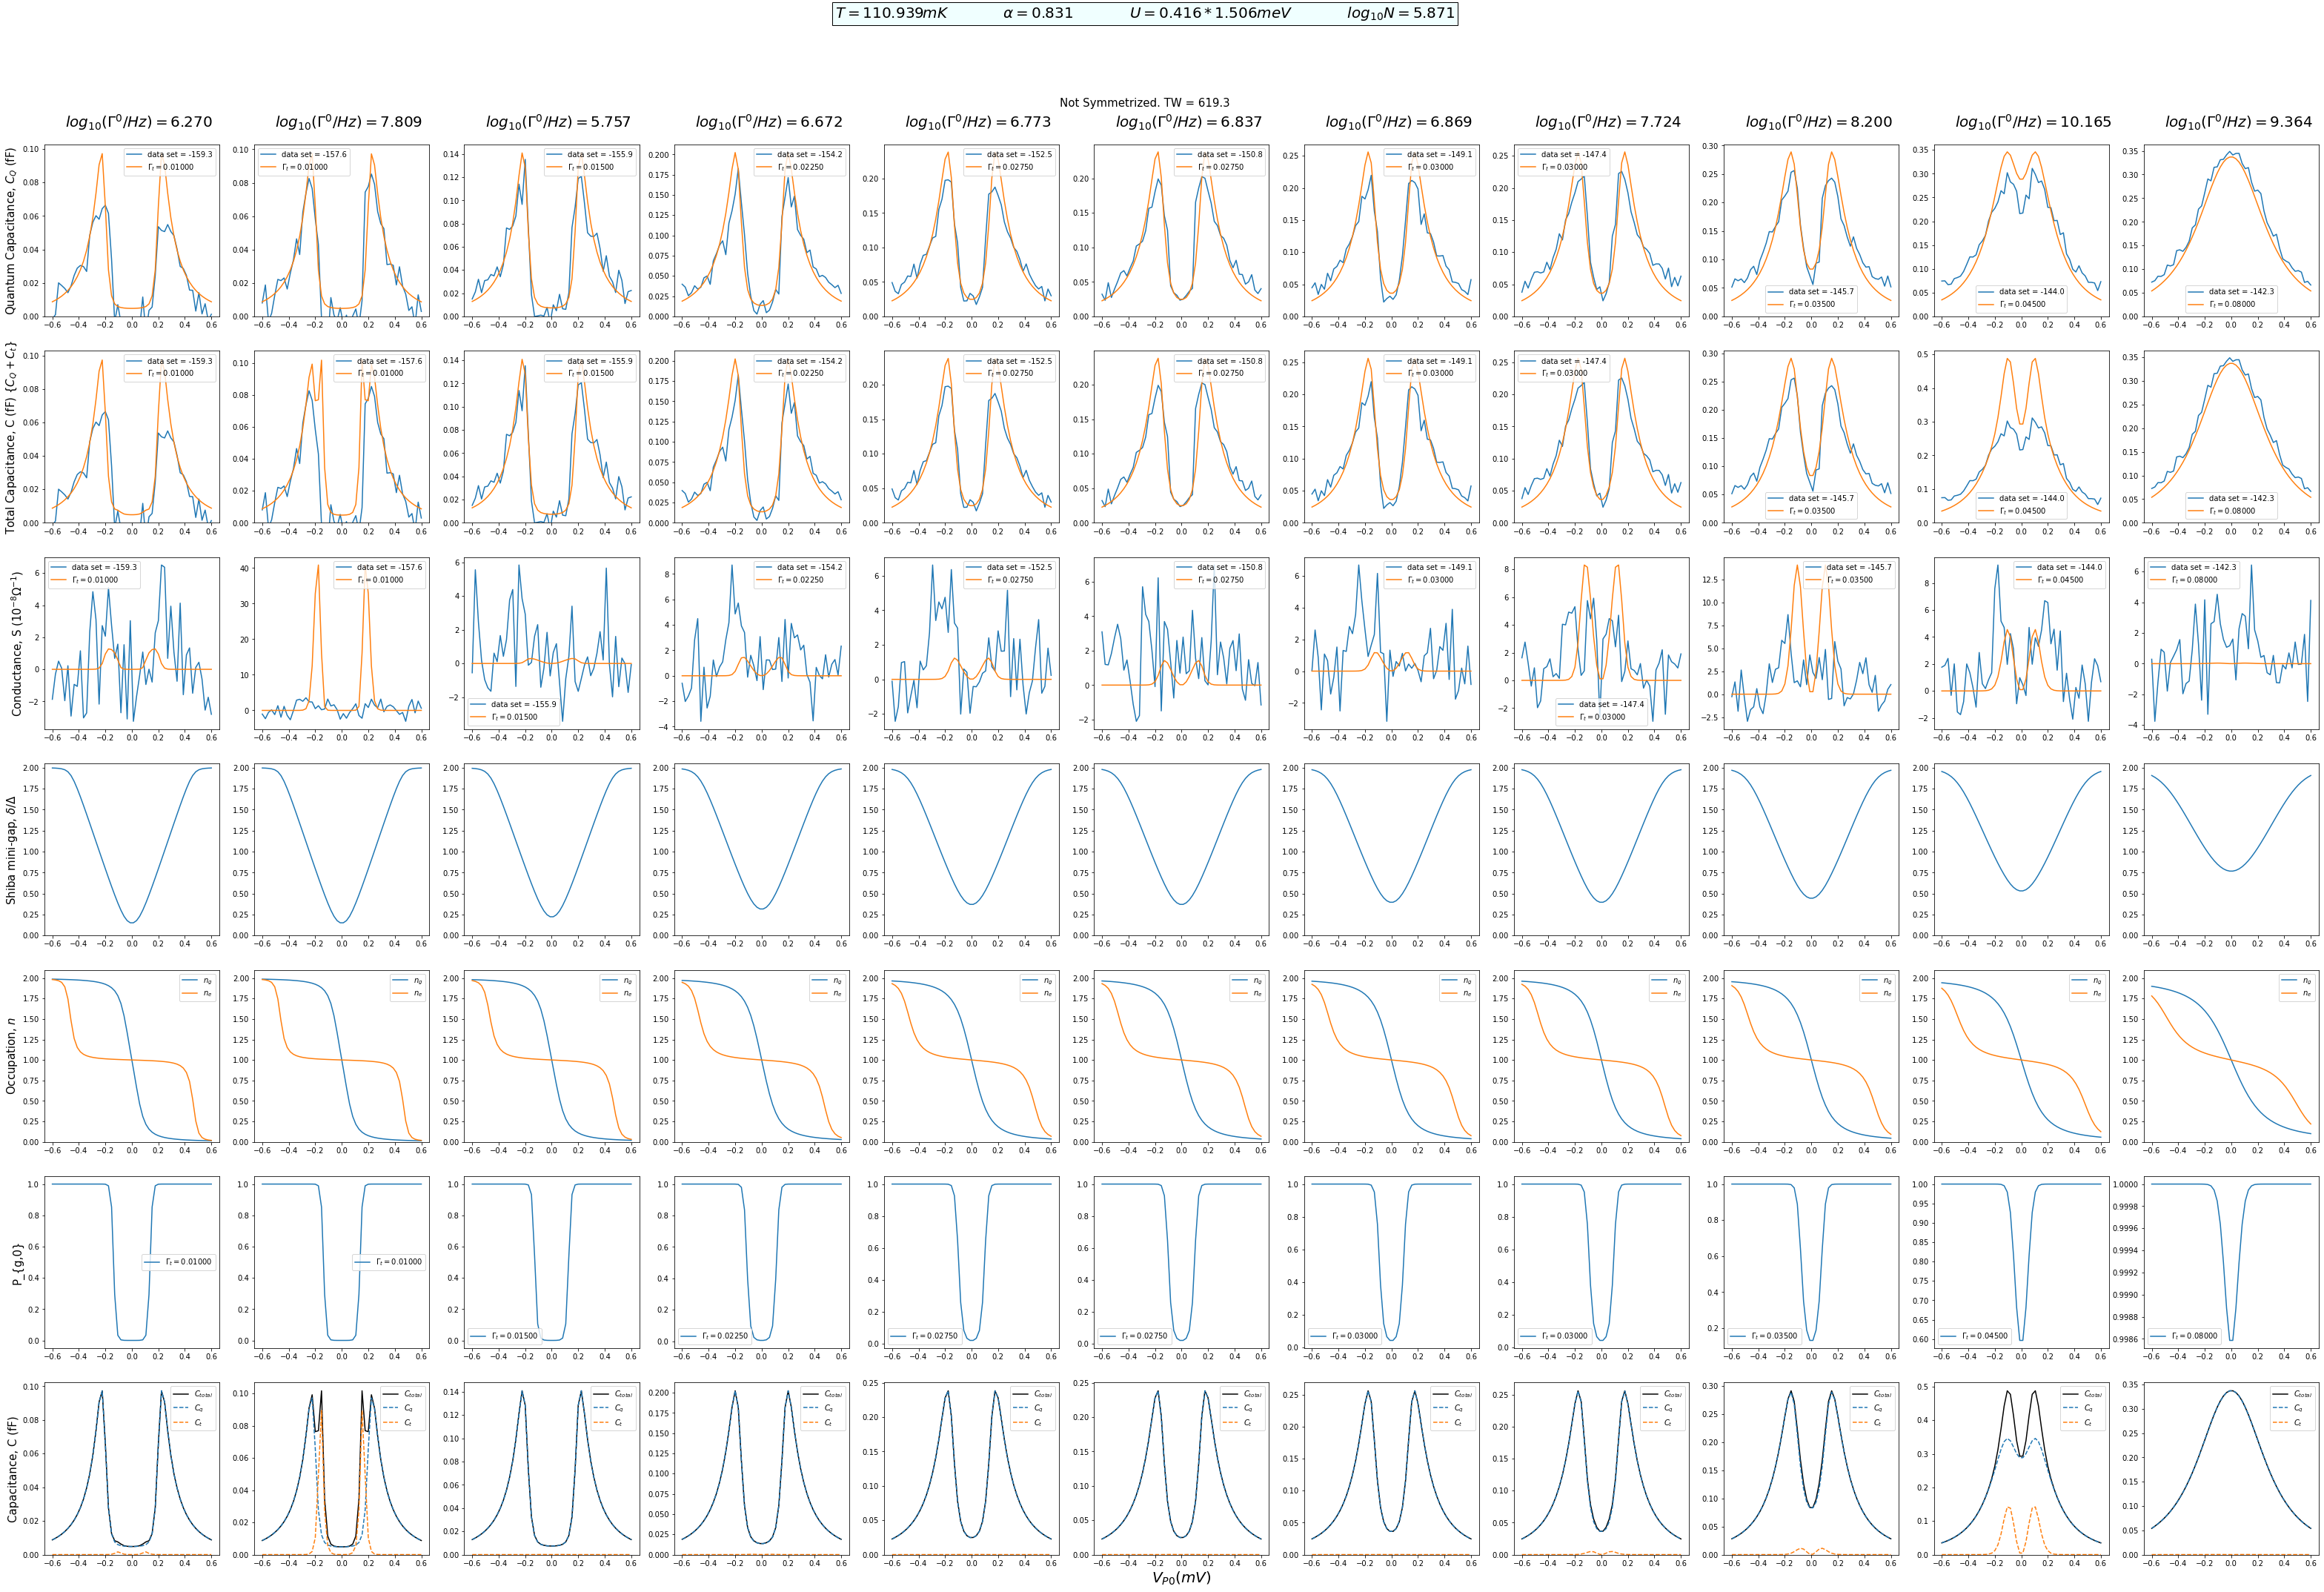

In [300]:
fitting_plot_grid(STEP2_RESULT[2],0,save=True)

In [301]:
def linlog(full_result,sym,save=False):
    plt.close()
    fig, axis = plt.subplots(1,1,figsize=(7,5))
    u, alpha, temp, log_n, *dissipative_parameters = full_result
    global_parameters = (u, alpha, temp, log_n)
    dissipative_parameters = np.array(dissipative_parameters)
    gamma_values = [float(min_gamma_weight(sets, global_parameters, sym)[0]) for sets in DATA_SETS_LIST]    
    
    axis.scatter(gamma_values, np.log10(10**dissipative_parameters), 15, 'red')
    axis.set_xlabel('$\Gamma_t$ (meV)', fontsize=13)
    axis.set_ylabel('$\log_{10}(\Gamma_0 / Hz)$', fontsize=13)
    axis.set_title('$log(\Gamma_0 / Hz)$ vs $\Gamma_t$', fontsize=13)
    parameter_string = f"$T = {temp*1000:.3f} mK $\
            $\\alpha        = {alpha:.3f} $\
            $U       = {u:.3f} meV $\
            $log_{{10}} N   = {log_n:.3f}$"

    fig.text(0.5, 0.96, parameter_string, ha='center', va='center', wrap=False,
            bbox=dict(ec='black', alpha=1, color='azure'), fontsize=10)
    
    if save:
        if sym:
            plt.savefig(f"logG0-Gt_sym_{[f'{member[0]}{member[1]:.2f}_' for member in zip(['U-', 'alpha-', 'mK_T-', 'log_N-'],global_parameters)]}.pdf", format='pdf')
            plt.savefig(f"logG0-Gt_sym_{[f'{member[0]}{member[1]:.2f}_' for member in zip(['U-', 'alpha-', 'mK_T-', 'log_N-'],global_parameters)]}.svg", format='svg')

        else:
            plt.savefig(f"logG0-Gt_not-sym_{[f'{member[0]}{member[1]:.2f}_' for member in zip(['U-', 'alpha-', 'mK_T-', 'log_N-'],global_parameters)]}.pdf", format='pdf')
            plt.savefig(f"logG0-Gt_not-sym_{[f'{member[0]}{member[1]:.2f}_' for member in zip(['U-', 'alpha-', 'mK_T-', 'log_N-'],global_parameters)]}.svg", format='svg')


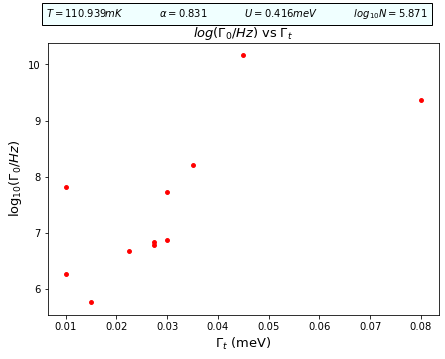

In [302]:
linlog(STEP2_RESULT[2],0,False)

In [303]:
def loglog(full_result,sym,save=False):
    plt.close()
    fig, axis = plt.subplots(1,1,figsize=(7,5))
    u, alpha, temp, log_n, *dissipative_parameters = full_result
    global_parameters = (u, alpha, temp, log_n)
    dissipative_parameters = np.array(dissipative_parameters)
    gamma_values = [float(min_gamma_weight(sets, global_parameters, sym)[0]) for sets in DATA_SETS_LIST]
    
    slope, intercept, _, _, _ = linregress(np.log10(gamma_values), dissipative_parameters)
    
    gamma_range = np.log10(np.linspace(np.min(gamma_values), np.max(gamma_values), 100))
    axis.plot(gamma_range, slope*gamma_range + intercept, 'k')
    axis.text(0.2, 0.8, f'Slope = {slope:.3f}\nIntercept = {intercept:.3f}', transform=axis.transAxes, fontsize=15)
    
    axis.scatter(np.log10(gamma_values), dissipative_parameters, 10, 'red')
#     axis.plot(np.log10(gamma_values), dissipative_parameters)
    axis.set_xlabel('$\log_{10}(\Gamma_t / meV)$',fontsize=13)
    axis.set_ylabel('$\log_{10}(\Gamma_0 / Hz)$',fontsize=13)
    axis.set_title('$\log_{10}(\Gamma_0 / Hz)$ vs $\log_{10}(\Gamma_t / meV)$',fontsize=13,y=0.985)
    parameter_string = f"$T = {temp*1000:.3f} mK $\
            $\\alpha        = {alpha:.3f} $\
            $U       = {u:.3f} meV $\
            $log_{{10}} N   = {log_n:.3f}$"

    fig.text(0.5, 0.96, parameter_string, ha='center', va='center', wrap=False,
            bbox=dict(ec='black', alpha=1, color='azure'), fontsize=10)
    
    if save:
        if sym:
            plt.savefig(f"logG0-logGt_sym_{[f'{member[0]}{member[1]:.2f}_' for member in zip(['U-', 'alpha-', 'mK_T-', 'log_N-'],global_parameters)]}.pdf", format='pdf')
            plt.savefig(f"logG0-logGt_sym_{[f'{member[0]}{member[1]:.2f}_' for member in zip(['U-', 'alpha-', 'mK_T-', 'log_N-'],global_parameters)]}.svg", format='svg')

        else:
            plt.savefig(f"logG0-logGt_not-sym_{[f'{member[0]}{member[1]:.2f}_' for member in zip(['U-', 'alpha-', 'mK_T-', 'log_N-'],global_parameters)]}.pdf", format='pdf')
            plt.savefig(f"logG0-logGt_not-sym_{[f'{member[0]}{member[1]:.2f}_' for member in zip(['U-', 'alpha-', 'mK_T-', 'log_N-'],global_parameters)]}.svg", format='svg')


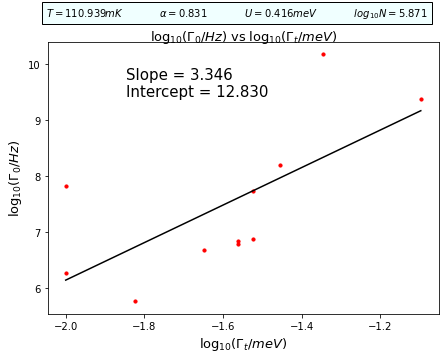

In [304]:
loglog(STEP2_RESULT[2],0,False)

In [305]:
def update_fit_plot(full_result,sym,capa,save=False):
    

    
    
    
    
    plt.close()
    u, alpha, temp, log_n, *dissipative_parameters = full_result
    dissipative_parameters = tuple(dissipative_parameters)
    global_parameters = (u, alpha, temp, log_n)
    gamma_values = [min_gamma_weight(sets, global_parameters, sym)[0] for sets in DATA_SETS_LIST]
    scale = 6
    fig, axes = plt.subplots(2,6,figsize=(12*scale,3*scale))
    
    axes = axes.flatten()
    fig.delaxes(axes[-1])

    for gamma, dset, log_g0, axis in zip(gamma_values,DATA_SETS_LIST,dissipative_parameters,axes):
        
        exp_v, exp_c, exp_g = experimental_data(dset, sym)
        q_cap, caps, cond = analytical_data(gamma, log_g0, global_parameters, exp_v, fit_step = 2)
        linewidth = 5
        if capa:
            axis.plot(exp_v, exp_c,label=f'data = {dset}',linewidth=linewidth)
            axis.plot(exp_v, caps,label=f'$\Gamma_t = ${gamma}',linewidth=linewidth)
            axis.legend(fontsize=18, bbox_to_anchor=(-0.1, 0.9, 1, .2),ncol=2)
            axis.tick_params(axis='both', which='major', labelsize=20)


#             axis.legend(fontsize=20,bbox_to_anchor=[0.1,0.1,.1,0.1])
            axis.set_ylim(0.0,None)
        else:
            axis.plot(exp_v, exp_g, label=f'data = {dset}',linewidth=linewidth)
            axis.plot(exp_v, cond, label=f'$\Gamma_t = ${gamma}',linewidth=linewidth)
            axis.legend(fontsize=20)
    if capa:
        axes[0].set_ylabel('Total Capacitance, C (fF) \n{$C_Q + C_t$}',fontsize=25)
        axes[6].set_ylabel('Total Capacitance, C (fF) \n{$C_Q + C_t$}',fontsize=25)
    else:
        axes[0].set_ylabel('Conductance, S ($10^{-8} \Omega^{-1}$)',fontsize=25)
        axes[6].set_ylabel('Conductance, S ($10^{-8} \Omega^{-1}$)',fontsize=25)
    
    axes[8].set_xlabel(r'$V_{P0} (mV) $',fontsize=25)
         
    parameter_string = f"$T = {temp*1000:.3f} mK $\
            $\\alpha        = {alpha:.3f} $\
            $U       = {u:.3f} meV $\
            $log_{{10}} N   = {log_n:.3f}$"
    
    fig.text(
        0.5, 0.95, parameter_string, ha='center', va='center', wrap=False,
        bbox=dict(ec='black', alpha=1, color='azure'), fontsize=20)
    
#     if capa:
    if sym:
        fig.text(
        0.5, 0.902, f"Symmetrized. TW = {total_weight2(dissipative_parameters, global_parameters, sym):.1f}", ha='center', va='center', wrap=False,
        bbox=dict(ec='black', alpha=0, color='azure'), fontsize=15)
    if not sym:
        fig.text(
        0.5, 0.92, f"Not Symmetrized. TW = {total_weight2(dissipative_parameters, global_parameters, sym):.1f}", ha='center', va='center', wrap=False,
        bbox=dict(ec='black', alpha=0, color='azure'), fontsize=20)
    
    if save:
        if sym:
            plt.savefig(f"update_grid_sym_{[f'{member[0]}{member[1]:.2f}_' for member in zip(['U-', 'alpha-', 'mK_T-', 'log_N-'],global_parameters)]}.pdf", format='pdf')
        else:
            plt.savefig(f"update_grid_not-sym_{[f'{member[0]}{member[1]:.2f}_' for member in zip(['U-', 'alpha-', 'mK_T-', 'log_N-'],global_parameters)]}.pdf", format='pdf')


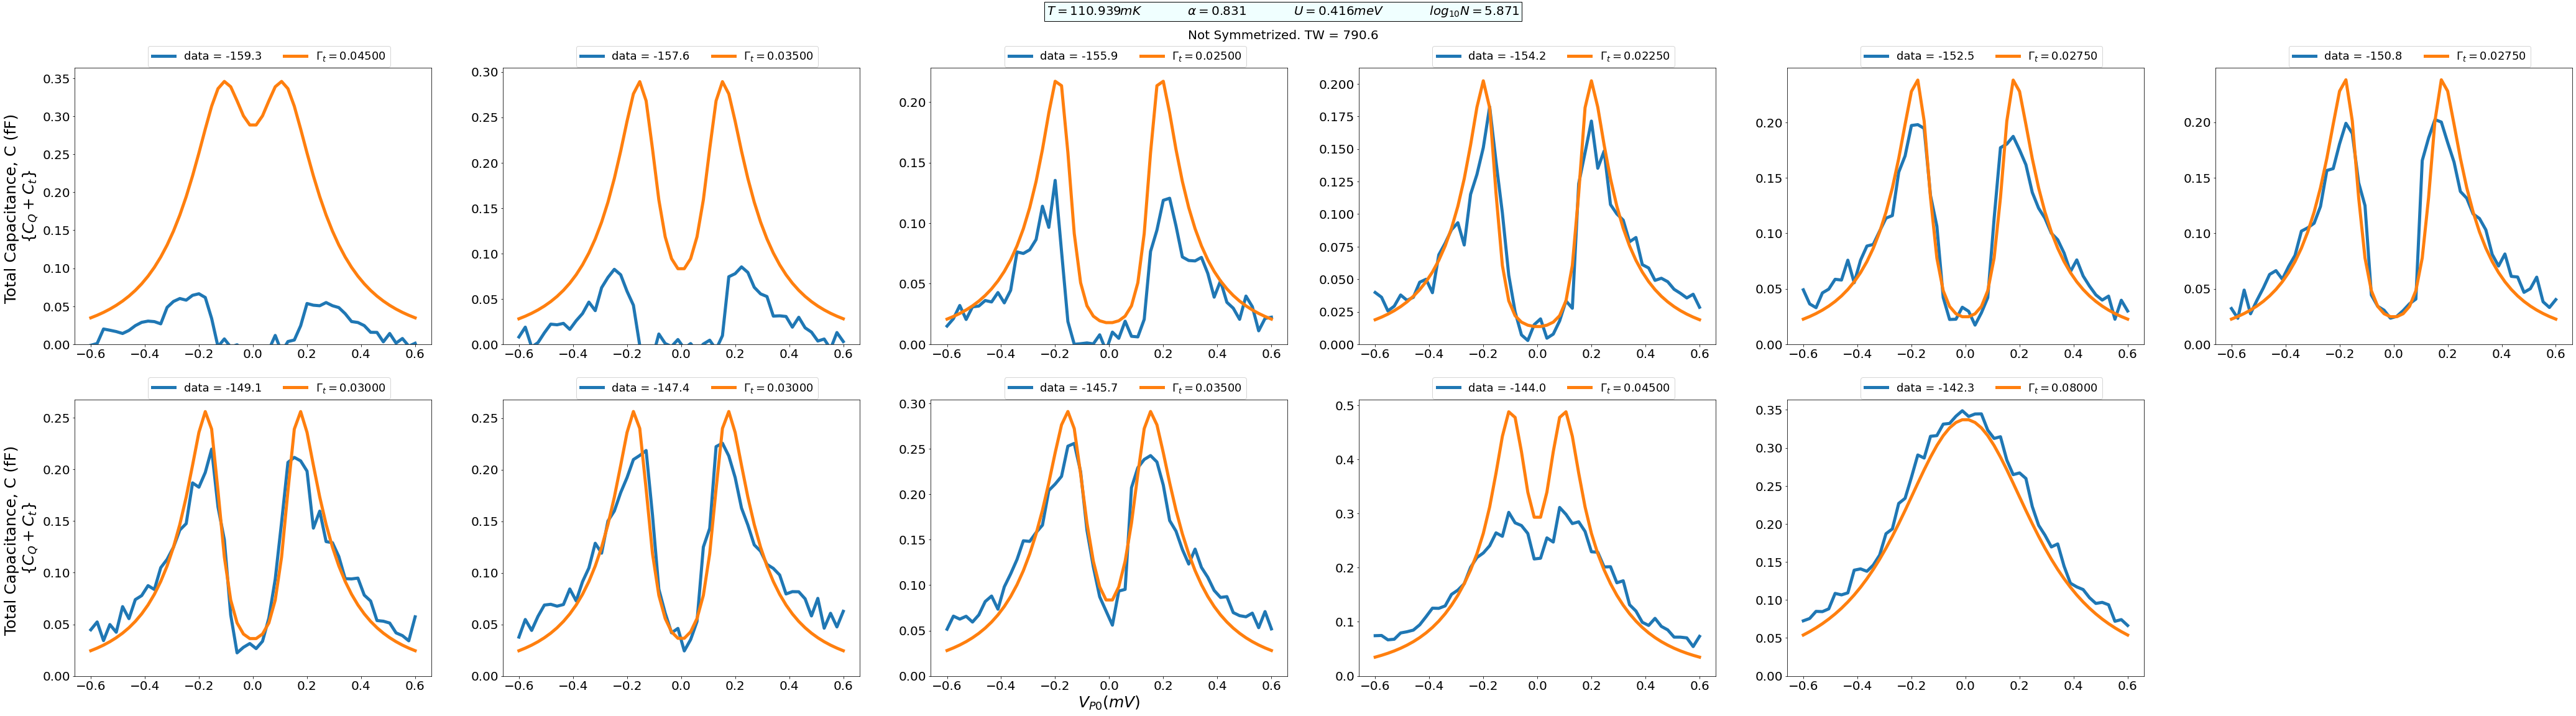

In [331]:
update_fit_plot(STEP2_RESULT[2], 0, 1, 1)

In [84]:
gamma_values = np.array([min_gamma_weight(sets, GLOBAL_OPTIMALS, 0)[0] for sets in DATA_SETS_LIST])
gamma_values

array(['0.01000', '0.01000', '0.01500', '0.02250', '0.02750', '0.02750',
       '0.03000', '0.03000', '0.03500', '0.10000', '0.08000'], dtype='<U7')

In [85]:
GLOBAL_OPTIMALS

array([0.416     , 0.82933059, 0.10589061, 6.09265099])

In [155]:
def paramfile(full_result,filename):
    gamma_values = np.array([min_gamma_weight(sets, full_result[:4], 0)[0] for sets in DATA_SETS_LIST])
    headder = ['data set', 'log_g0', 'Gamma_t', 'u', 'alpha', 'temperature', 'log_n']
    u, alpha, temp, log_n, *dissipative_parameters = full_result
    
    with open(filename, 'w') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(headder)
        for dset, gamma_zero, gamma_t in zip(DATA_SETS_LIST, dissipative_parameters, gamma_values):
            csvwriter.writerow([dset, gamma_zero, gamma_t, u, alpha, temp, log_n])


In [157]:
paramfile(STEP2_RESULT[2],'parameter_NewData_delta-0.25_binmin.csv')

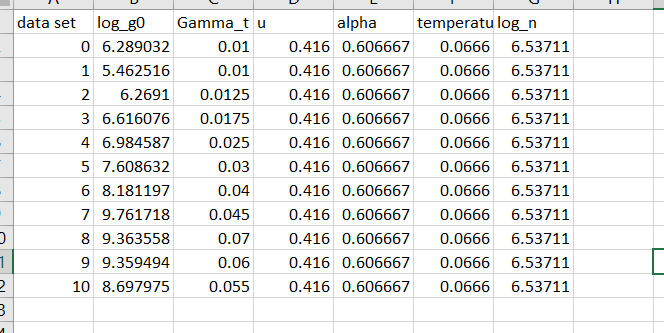

In [ ]:
PARAMETER_PATH = "G:\\My Drive\\GROWTH\\Quantum computing\\Majorana Project\\parameter.csv"
EXPERIMENTAL_PATH = "G:\\My Drive\\GROWTH\\Quantum computing\\Majorana Project\\Experimental data\\data-oct4-21-mail-filip\\data\\"
NRG_PATH = "G:\\My Drive\\GROWTH\\Quantum computing\\Majorana Project\\f1web.ijs.si\\~zitko\\data\\chi\\"

In [ ]:
PARAMETERS = np.loadtxt(PARAMETER_PATH, skiprows = 1, delimiter = ',')


In [51]:


PARAMETERS = np.loadtxt(PARAMETER_PATH, skiprows = 1, delimiter = ',')
CHOOSE_DATA_SETS = ('00','01','05')
EXPERIMENTAL_BOOL = True
LEGEND_BOOL = True
X_LABEL = True
Y_LABEL = True
X_COMMON = True
Y_COMMON = True
SAVE = True
FORMAT = 'pdf' # 'svg','png'
CHOOSE_QUANTITIES = ('conductance',
                     'total_cap',
                     't_cap',
                     'q_cap',
                     'q_cap_gs',
                     'q_cap_es',
                     'P0',
                     'mini_gap',
                     'n_gs',
                     'n_es',
                     'dn_gs',
                     'dn_es',
                     'gamma', # defined in cell #2
                     'etta',
                     'lambda'
                    )

In [52]:
PARAMETERS[0]

array([0.        , 6.28903214, 0.01      , 0.416     , 0.60666666,
       0.06659992, 6.53711   ])

In [ ]:
def on_demand_plot(full_result,sym,save=False):
    plt.close()
    u, alpha, temp, log_n, *dissipative_parameters = full_result
    dissipative_parameters = tuple(dissipative_parameters)
    global_parameters = (u, alpha, temp, log_n)
    gamma_values = [min_gamma_weight(sets, global_parameters, sym)[0] for sets in DATA_SETS_LIST]

    scale = 5
    fig, axes = plt.subplots(7,len(dissipative_parameters),figsize=(len(dissipative_parameters)*scale,7*scale))

    for gamma, dset, log_g0, axis1,axis2,axis3,axis4,axis5,axis6,axis7 in zip(gamma_values,DATA_SETS_LIST,dissipative_parameters,*axes):
        
        exp_v, exp_c, exp_g = experimental_data(dset, sym)
        q_cap, caps, cond = analytical_data(gamma, log_g0, global_parameters, exp_v, fit_step = 2)
        
        axis1.text(0.35,1.1,f'$log_{{10}} (\\Gamma^0 / Hz) = {log_g0:.3f}$',transform=axis1.transAxes)
        axis1.plot(exp_v, exp_c, label=f'data set = {dset}')
        axis1.plot(exp_v, q_cap, label=f'$\Gamma_t = ${gamma}')
        axis1.legend()
        axis1.set_ylim(0.0,None)
        
        axis2.plot(exp_v, exp_c, label=f'data set = {dset}')
        axis2.plot(exp_v, caps, label=f'$\Gamma_t = ${gamma}')
        axis2.legend()
        axis2.set_ylim(0.0,None)
        
        axis3.plot(exp_v, exp_g, label=f'data set = {dset}')
        axis3.plot(exp_v, cond, label=f'$\Gamma_t = ${gamma}')
        axis3.legend()
        
        v0 = exp_v*alpha
        nu = (1 - (v0/u))
        o1, n1, n2 = nrg_data_func(u,gamma)
        
        s_mg = np.interp(nu, o1[:,0], o1[:,1])
        axis4.plot(exp_v, s_mg, label=f'$\Gamma_t = ${gamma}')
        axis4.set_ylim(0.0,2.05)
        
        n_g = np.interp(nu, n1[:,0], n1[:,1])
        n_e = np.interp(nu, n2[:,0], n2[:,1])

        axis5.plot(exp_v, n_g,label=f'$n_g$')
        axis5.plot(exp_v, n_e,label=f'$n_e$')
        axis5.legend()
        axis5.set_ylim(0.0,2.1)
        
        P0g = p0(s_mg*DELTA, temp, 10**log_n)
        axis6.plot(exp_v,P0g,label=f'$\Gamma_t = ${gamma}')
        axis6.legend()
        
        t_cap = caps - q_cap
        axis7.plot(exp_v, caps, 'k', label=r'$C_{total}$')
        axis7.plot(exp_v, q_cap, '--', label=r'$C_q$')
        axis7.plot(exp_v, t_cap, '--', label=r'$C_t$')
        axis7.legend()
        axis7.set_ylim(0.0,None)

    axes[0][0].set_ylabel(r'Quantum Capacitance, $C_Q$ (fF)',fontsize=15)
    axes[1][0].set_ylabel(r'Total Capacitance, C (fF) {$C_Q + C_t$}',fontsize=15)
    axes[2][0].set_ylabel(r'Conductance, S ($10^{-8} \Omega^{-1}$)',fontsize=15)
    axes[3][0].set_ylabel(r'Shiba mini-gap, $\delta / \Delta $',fontsize=15)
    axes[4][0].set_ylabel(r'Occupation, $n$',fontsize=15)
    axes[5][0].set_ylabel(r'P_{g,0}',fontsize=15)
    axes[6][0].set_ylabel('Capacitance, C (fF)',fontsize=15)
    axes[6][5].set_xlabel(r'$V_{P0} (mV) $',fontsize=20)
         
    parameter_string = f"$T = {temp*1000:.3f} mK $\
            $\\alpha        = {alpha:.3f} $\
            $U       = {u:.3f} meV $\
            $log_{{10}} N   = {log_n:.3f}$"
    
    fig.text(
        0.5, 0.95, parameter_string, ha='center', va='center', wrap=False,
        bbox=dict(ec='black', alpha=1, color='azure'), fontsize=20)
    
    if sym:
        fig.text(
        0.5, 0.902, f"Symmetrized. TW = {total_weight2(dissipative_parameters, global_parameters, sym):.1f}", ha='center', va='center', wrap=False,
        bbox=dict(ec='black', alpha=0, color='azure'), fontsize=15)
    if not sym:
        fig.text(
        0.5, 0.902, f"Not Symmetrized. TW = {total_weight2(dissipative_parameters, global_parameters, sym):.1f}", ha='center', va='center', wrap=False,
        bbox=dict(ec='black', alpha=0, color='azure'), fontsize=15)
    
    if save:
        if sym:
            plt.savefig(f"2D_grid_sym_{[f'{member[0]}{member[1]:.2f}_' for member in zip(['U-', 'alpha-', 'mK_T-', 'log_N-'],global_parameters)]}.pdf", format='pdf')
        else:
            plt.savefig(f"2D_grid_not-sym_{[f'{member[0]}{member[1]:.2f}_' for member in zip(['U-', 'alpha-', 'mK_T-', 'log_N-'],global_parameters)]}.pdf", format='pdf')
      